In [1]:
import torch
import torch.nn as nn

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
DOWNLOAD_DATA = False
UNZIP = False
DELETE_DATA = False
MAKE_DEV_FILE = False

DEV_RECORD_COUNT = 150000

In [3]:
if DOWNLOAD_DATA:
    !kaggle competitions download -c new-york-city-taxi-fare-prediction

In [4]:
if UNZIP:
    !unzip train.csv.zip

In [5]:
# We are just sampling across all time, which means it's possible
# we aren't sampling from the same distribution as the tutorial. It's
# clear that the centr of our fares is higher. The video uses 2010, I think.
if MAKE_DEV_FILE:
    import random
    df = pd.read_csv('train.csv')
    sample = df.sample(DEV_RECORD_COUNT, random_state=42)
    sample.to_csv('dev.csv', index=False)
    del sample
    del df
    df = pd.read_csv('dev.csv')
else:
    df = pd.read_csv('dev.csv')

In [6]:
if DELETE_DATA:
    !rm train.csv
    !rm train.csv.zip

In [7]:
df.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2010-01-16 20:06:00.000000168,3.3,2010-01-16 20:06:00 UTC,-73.953323,40.778532,-73.953375,40.772505,1
1,2010-09-22 23:21:00.00000065,6.5,2010-09-22 23:21:00 UTC,-73.985542,40.738333,-74.003350,40.738935,1
2,2013-10-17 18:40:14.0000001,5.0,2013-10-17 18:40:14 UTC,-73.999945,40.718097,-73.999239,40.723103,1
3,2015-06-09 19:39:42.0000009,40.5,2015-06-09 19:39:42 UTC,-73.974533,40.756237,-73.923149,40.867210,1
4,2012-05-01 07:16:59.0000001,7.7,2012-05-01 07:16:59 UTC,-73.952835,40.786351,-73.974022,40.762765,1


In [8]:
df.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,150000.000000,150000.000000,150000.000000,149999.000000,149999.000000,150000.000000
mean,11.295062,-72.504976,39.905469,-72.507915,39.894913,1.678553
std,9.651060,13.399632,10.900223,13.144519,13.620646,1.302309
min,-45.000000,-736.400000,-3430.761308,-90.239125,-3430.761308,0.000000
25%,6.000000,-73.992037,40.734880,-73.991462,40.734059,1.000000
50%,8.500000,-73.981802,40.752696,-73.980116,40.753115,1.000000
75%,12.500000,-73.967072,40.767190,-73.963763,40.767988,2.000000
max,227.000000,3061.872988,440.781892,3061.872988,407.000000,6.000000


In [9]:
# To compute the distance between two corrdinates, we will use
# the haversine formula. DO WE GET BETTER ACCURACY WITH STREET
# DISTANCE? 

def haversine_distance(df, lat1, long1, lat2, long2):
    AVG_RADIUS_EARTH = 6371
    
    phi1 = np.radians(df[lat1])
    phi2 = np.radians(df[lat2])
    
    delta_phi = np.radians(df[lat2] - df[lat1])
    delta_lambda = np.radians(df[long2] - df[long1])
    
    a = np.sin(delta_phi/2)**2 + np.cos(phi1)*np.cos(phi2)*np.sin(delta_lambda/2)**2
    c = 2*np.arctan2(np.sqrt(a), np.sqrt(1-a))
    d = AVG_RADIUS_EARTH*c
    
    return d

In [10]:
df['distance_km'] = haversine_distance(df, 'pickup_latitude', 
                                       'pickup_longitude', 
                                       'dropoff_latitude',
                                       'dropoff_longitude')

In [11]:
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])

In [12]:
df['edt_date'] = df['pickup_datetime'] - pd.Timedelta(hours=4)

In [13]:
df['hour'] = df['edt_date'].dt.hour

In [14]:
df['am_or_pm'] = df['hour'].apply(lambda x: 'am' if x < 12 else 'pm')

In [15]:
df['weekday'] = df['edt_date'].dt.strftime('%a')

In [16]:
df.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance_km,edt_date,hour,am_or_pm,weekday
0,2010-01-16 20:06:00.000000168,3.3,2010-01-16 20:06:00+00:00,-73.953323,40.778532,-73.953375,40.772505,1,0.670186,2010-01-16 16:06:00+00:00,16,pm,Sat
1,2010-09-22 23:21:00.00000065,6.5,2010-09-22 23:21:00+00:00,-73.985542,40.738333,-74.003350,40.738935,1,1.501848,2010-09-22 19:21:00+00:00,19,pm,Wed
2,2013-10-17 18:40:14.0000001,5.0,2013-10-17 18:40:14+00:00,-73.999945,40.718097,-73.999239,40.723103,1,0.559813,2013-10-17 14:40:14+00:00,14,pm,Thu
3,2015-06-09 19:39:42.0000009,40.5,2015-06-09 19:39:42+00:00,-73.974533,40.756237,-73.923149,40.867210,1,13.075483,2015-06-09 15:39:42+00:00,15,pm,Tue
4,2012-05-01 07:16:59.0000001,7.7,2012-05-01 07:16:59+00:00,-73.952835,40.786351,-73.974022,40.762765,1,3.171938,2012-05-01 03:16:59+00:00,3,am,Tue


In [17]:
cat_cols = ['hour', 'am_or_pm', 'weekday']
cont_cols = ['pickup_latitude', 'dropoff_latitude', 
             'pickup_longitude', 'dropoff_longitude',
             'distance_km', 'passenger_count']
y_col = ['fare_amount']

In [18]:
for cat in cat_cols:
    df[cat] = df[cat].astype('category')

In [19]:
cats = np.stack([
    df[col].cat.codes.values for col in cat_cols
], axis=1)

In [20]:
cats = torch.tensor(cats, dtype=torch.int64)

In [21]:
conts = np.stack([
    df[col].values for col in cont_cols
], axis=1)

In [22]:
conts = torch.tensor(conts, dtype=torch.float)

In [23]:
conts

tensor([[ 40.7785,  40.7725, -73.9533, -73.9534,   0.6702,   1.0000],
        [ 40.7383,  40.7389, -73.9855, -74.0033,   1.5018,   1.0000],
        [ 40.7181,  40.7231, -73.9999, -73.9992,   0.5598,   1.0000],
        ...,
        [ 40.7480,  40.7551, -73.9851, -73.9942,   1.0969,   1.0000],
        [ 40.7645,  40.7952, -73.9715, -73.9695,   3.4115,   1.0000],
        [ 40.7584,  40.7329, -73.9742, -73.9904,   3.1482,   5.0000]])

In [24]:
y = torch.tensor(df[y_col].values, dtype=torch.float).reshape(-1, 1)

In [25]:
y

tensor([[3.3000],
        [6.5000],
        [5.0000],
        ...,
        [9.5000],
        [8.5000],
        [8.5000]])

In [26]:
cats.shape, conts.shape, y.shape

(torch.Size([150000, 3]), torch.Size([150000, 6]), torch.Size([150000, 1]))

In [27]:
category_sizes = [
    len(df[col].cat.categories) for col in cat_cols
]

In [28]:
category_sizes

[24, 2, 7]

In [29]:
# Instead of one hot encodings, we are using embeddings. This is a strange
# thing to do, but I'll cope
emb_sizes = [(size, min(50, size+1)//2) for size in category_sizes]

In [30]:
emb_sizes

[(24, 12), (2, 1), (7, 4)]

In [31]:
# Walking through how the embeddings work
selfembeds = nn.ModuleList([
    nn.Embedding(n_embeddings, dim) 
    for n_embeddings, dim 
    in emb_sizes
])

In [32]:
selfembeds

ModuleList(
  (0): Embedding(24, 12)
  (1): Embedding(2, 1)
  (2): Embedding(7, 4)
)

In [33]:
catz = cats[:4]
embeddingz = []

# Embedding outputs
for i, e in enumerate(selfembeds):
    embeddingz.append(e(catz[:, i]))

In [34]:
embeddingz

[tensor([[ 1.4001, -0.8155, -0.3597, -0.3141, -1.7330, -0.1059, -1.0053,  0.3955,
           0.3389, -1.1147,  0.4868, -1.1228],
         [ 0.6758, -0.3011, -1.0026,  0.6504,  0.4235,  0.8122,  0.1853,  0.3083,
           0.3190,  1.5734, -0.0991,  0.6279],
         [-0.1113, -0.4950, -0.4202,  1.1434, -0.7137,  0.0040,  2.6959, -0.3960,
           0.2350, -0.1021,  0.0480,  0.2229],
         [ 2.0057, -0.0611,  0.6814, -0.6629, -1.0588, -1.5903,  2.4518,  0.0339,
          -1.6719, -0.4054,  1.1310, -0.2357]], grad_fn=<EmbeddingBackward>),
 tensor([[1.3289],
         [1.3289],
         [1.3289],
         [1.3289]], grad_fn=<EmbeddingBackward>),
 tensor([[ 1.2575, -1.4768,  1.5360,  0.2432],
         [-1.0507,  0.1469,  0.6436,  0.0988],
         [-2.7572,  0.4683,  0.1305,  0.9588],
         [-0.4994, -0.4432,  0.1864, -0.2781]], grad_fn=<EmbeddingBackward>)]

In [35]:
z = torch.cat(embeddingz, 1)

In [36]:
z

tensor([[ 1.4001, -0.8155, -0.3597, -0.3141, -1.7330, -0.1059, -1.0053,  0.3955,
          0.3389, -1.1147,  0.4868, -1.1228,  1.3289,  1.2575, -1.4768,  1.5360,
          0.2432],
        [ 0.6758, -0.3011, -1.0026,  0.6504,  0.4235,  0.8122,  0.1853,  0.3083,
          0.3190,  1.5734, -0.0991,  0.6279,  1.3289, -1.0507,  0.1469,  0.6436,
          0.0988],
        [-0.1113, -0.4950, -0.4202,  1.1434, -0.7137,  0.0040,  2.6959, -0.3960,
          0.2350, -0.1021,  0.0480,  0.2229,  1.3289, -2.7572,  0.4683,  0.1305,
          0.9588],
        [ 2.0057, -0.0611,  0.6814, -0.6629, -1.0588, -1.5903,  2.4518,  0.0339,
         -1.6719, -0.4054,  1.1310, -0.2357,  1.3289, -0.4994, -0.4432,  0.1864,
         -0.2781]], grad_fn=<CatBackward>)

In [37]:
selfembeddingdrop = nn.Dropout(0.4)

In [38]:
z = selfembeddingdrop(z)

In [39]:
z

tensor([[ 0.0000, -1.3591, -0.0000, -0.5235, -0.0000, -0.0000, -0.0000,  0.6592,
          0.5649, -0.0000,  0.0000, -1.8714,  2.2148,  0.0000, -0.0000,  2.5600,
          0.4054],
        [ 1.1264, -0.0000, -0.0000,  1.0839,  0.7058,  0.0000,  0.3088,  0.5138,
          0.5317,  2.6223, -0.1652,  1.0465,  0.0000, -0.0000,  0.2448,  0.0000,
          0.1647],
        [-0.0000, -0.0000, -0.7004,  1.9056, -0.0000,  0.0066,  0.0000, -0.6600,
          0.0000, -0.1702,  0.0000,  0.0000,  0.0000, -4.5953,  0.0000,  0.0000,
          1.5980],
        [ 3.3428, -0.1018,  0.0000, -0.0000, -0.0000, -2.6505,  4.0864,  0.0565,
         -0.0000, -0.6757,  0.0000, -0.3928,  0.0000, -0.0000, -0.7387,  0.3107,
         -0.0000]], grad_fn=<MulBackward0>)

In [40]:
class TabularModel(nn.Module):
    def __init__(self, 
                 embedding_sizes,
                 n_cont,
                 out_size,
                 layers,
                 dropout_prob=0.5):
        super().__init__()
        
        self.embeds = nn.ModuleList([
            nn.Embedding(ni, nf) for ni, nf in embedding_sizes
        ])
        self.emb_drop = nn.Dropout(dropout_prob)
        self.bn_cont = nn.BatchNorm1d(n_cont)
        
        layerlist = []
        n_embs = sum([nf for ni, nf in embedding_sizes])
        n_in = n_embs + n_cont
        
        # layers
        for i in layers:
            layerlist.append(nn.Linear(n_in, i))
            layerlist.append(nn.ReLU(inplace=True))
            layerlist.append(nn.BatchNorm1d(i))
            layerlist.append(nn.Dropout(dropout_prob))
            n_in = i
        layerlist.append(nn.Linear(layers[-1], out_size))
        
        self.layers = nn.Sequential(*layerlist)
    
    def forward(self, x_cat, x_cont):
        embeddings = []
        for i, e in enumerate(self.embeds):
            embeddings.append(e(x_cat[:, i]))
        x = torch.cat(embeddings, 1)
        x = self.emb_drop(x)
        
        x_cont = self.bn_cont(x_cont)
        x = torch.cat([x, x_cont], 1)
        x = self.layers(x)
        return x

In [41]:
torch.manual_seed(33)

model = TabularModel(emb_sizes, conts.shape[1], 1, [200, 100], dropout_prob=.4)

In [42]:
model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(24, 12)
    (1): Embedding(2, 1)
    (2): Embedding(7, 4)
  )
  (emb_drop): Dropout(p=0.4)
  (bn_cont): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=23, out_features=200, bias=True)
    (1): ReLU(inplace)
    (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4)
    (4): Linear(in_features=200, out_features=100, bias=True)
    (5): ReLU(inplace)
    (6): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.4)
    (8): Linear(in_features=100, out_features=1, bias=True)
  )
)

In [43]:
batch_size = 60000
test_size = int(batch_size*0.2)

In [44]:
cat_train = cats[:batch_size - test_size]
cat_test = cats[batch_size-test_size:batch_size]
con_train = conts[:batch_size-test_size]
con_test = conts[batch_size-test_size:batch_size]

In [45]:
y_train = y[:batch_size-test_size]
y_test = y[batch_size-test_size:batch_size]

In [46]:
len(cat_train), len(con_train)

(48000, 48000)

In [47]:
len(cat_test)

12000

In [48]:
import time

device = torch.device('cuda:0' if torch.cuda.is_available() else 'CPU')
model = model.to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

cat_train = cat_train.to(device)
con_train = con_train.to(device)
y_train = y_train.to(device)

start_time = time.time()

epochs = 600
losses = list()

for i in range(epochs):
    y_pred = model(cat_train, con_train)
    loss = torch.sqrt(criterion(y_pred, y_train))
    losses.append(loss)
    
    if i % 10 == 0:
        print(f'epoch: {i:3d} loss: {loss:.4f}')
        
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
duration = time.time() - start_time

print(f'Training took {duration/60} minutes')

epoch:   0 loss: 14.6914
epoch:  10 loss: 14.6382
epoch:  20 loss: 14.5754
epoch:  30 loss: 14.4905
epoch:  40 loss: 14.3814
epoch:  50 loss: 14.2463
epoch:  60 loss: 14.0732
epoch:  70 loss: 13.8750
epoch:  80 loss: 13.6345
epoch:  90 loss: 13.3761
epoch: 100 loss: 13.0822
epoch: 110 loss: 12.7580
epoch: 120 loss: 12.4264
epoch: 130 loss: 12.0848
epoch: 140 loss: 11.7455
epoch: 150 loss: 11.3834
epoch: 160 loss: 11.0455
epoch: 170 loss: 10.7431
epoch: 180 loss: 10.4440
epoch: 190 loss: 10.2089
epoch: 200 loss: 10.0100
epoch: 210 loss: 9.8507
epoch: 220 loss: 9.7410
epoch: 230 loss: 9.6467
epoch: 240 loss: 9.5648
epoch: 250 loss: 9.4422
epoch: 260 loss: 9.0317
epoch: 270 loss: 8.0576
epoch: 280 loss: 7.2180
epoch: 290 loss: 7.0893
epoch: 300 loss: 6.5993
epoch: 310 loss: 6.1860
epoch: 320 loss: 5.9745
epoch: 330 loss: 5.8254
epoch: 340 loss: 5.8058
epoch: 350 loss: 5.8207
epoch: 360 loss: 5.7086
epoch: 370 loss: 5.6943
epoch: 380 loss: 5.6444
epoch: 390 loss: 5.6467
epoch: 400 loss: 5.

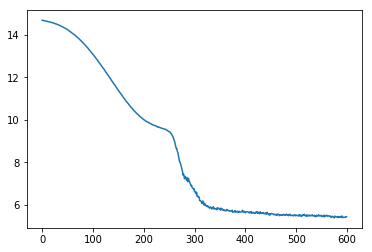

In [49]:
plt.plot(range(epochs), losses)